# Clasification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**2110ACDS_T7**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### EDSA-Climate Change Belief Analysis 2022


### Problem Statement

Our clients would like to know people's perception on climate change, whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received, which will increasing their insights and informing future marketing strategies.

SWAT_Team_7 has been consulted to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### Process

- 1. analyse the supplied data;
- 2. identify potential errors in the data and clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of forecasting the three hourly demand shortfalls;
- 5. evaluate the accuracy of the best machine learning model;
- 6. determine if a person believes in climate change or not, and
- 7. explain the inner working of the model to a non-technical audience.
  

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [201]:
import re
import string
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42


import warnings
warnings.filterwarnings('ignore')

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [3]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


### Data Analysis
For this section, we carry out two different types of data analysis:
- Univariate \
    i. non-graphical \
    ii. graphical 
- Multivariate \
    i. non-graphical \
    ii. graphical

#### Univariate Non-Graphical Analysis
For this analysis, we are going to view dataset on the below checks:  \
    i.  Check for the presence of *null* values  \
    ii. Descriptive statistical values *mean, std, minimum, quatiles, maximum, and kurtosis*  
    iii. Dataset data types

In [4]:
# look at data statistics
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [5]:
# Check data types for all columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
# look at data statistics
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment,15819.0,0.917504,0.836537,-1.0,1.0,1.0,1.0,2.0
tweetid,15819.0,501719.433656,289045.983132,6.0,253207.5,502291.0,753769.0,999888.0


In [9]:
df_train.kurtosis()

sentiment    0.122976
tweetid     -1.193356
dtype: float64

From the above analysis thus far, it is evidence that we only have two numeric colunms. 
However we suspect that one of these columns(tweetid) contains unique values in each row, while the other column(sentiment) from the name, we infere that it is our label, hence contains a minimum of two different values.

To confirm the above, we write a function that takes in a dataframe and a column-id, to give an output which is the number of unique values in the column as an integer.

In [22]:
def unique_val(df, col):
    """
        This function takes in a dataframe and a column name, 
        and ouputs an interger, which is the number of unique 
        values in the column.
    """
    return df[col].nunique()

In [25]:
# Check the numbers of unique values for the sentiment column
print(f'The numbers of unique values in the sentiment column is : {unique_val(df_train, "sentiment")}')

The numbers of unique values in the sentiment column is : 4


In [26]:
# Check the numbers of unique values for the tweetid column
print(f'The numbers of unique values in the tweetid column is : {unique_val(df_train, "tweetid")}')

The numbers of unique values in the tweetid column is : 15819


From the above results, the sentiment column contains four different unique values, and we want to see how this values
are distributed in the column.
To achieve this, we write a function called *unique_val_count*.

In [39]:
def unique_val_count(df, col):
    """
        This function takes in a dataframe and a column name, 
        and ouputs a dictionary, which contains the unique values as a key, and the numbers as values.
    """
    distribution = {}
    unique_vals = df[col].unique()
    for val in unique_vals:
        distribution[val] = df[df[col] == val][col].count()
    
    return distribution

In [40]:
unique_val_count(df_train, 'sentiment')

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

### Univariate graphical inspection of data
For this analysis, we view the individual colunms using histogram plot.

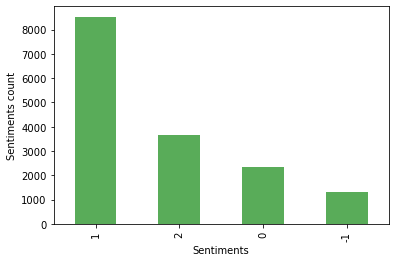

In [58]:
# Bar plot of label classes
fig,ax = plt.subplots()
df_train['sentiment'].value_counts().plot(kind = 'bar', facecolor='g', alpha=0.65)
ax.set_xlabel('Sentiments')
ax.set_ylabel('Sentiments count')
plt.show()

# PUT IN WORD CLOUD BELOW

## Also include findings from world cloud in EDA summary

### EDA summary
- The dataset contains three columns (sentiments, message and tweetid)
- Sentiments and tweetid are of numeric data type, while message is non-numeric
- tweetid is a clumn with uniques values acreoss the entire rows of the dataset
- sentiments columns contains for different unique values (-1, 0, 1 &2) with different sizes

In [ ]:
# have a look at feature distributions

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

## Text Cleaning

### Removing Noise

For the given dataset, we identified that the *message* column contains the novel tweet for each userid, which we are espected to classify. 
For us to proceed we have to carry out cleaning on this messages. This cleaning will be achieved through:
* identify and remove web-urls from the main message 
* idendify and remove words started with '#'
* idendify and remove words started with '@'
* making everything lower case
* removing punctuation



#### Remove web-url from message

We write a function called *delete_url*. This function uses regex to identify web-url in a column and remove same from the column.

In [150]:
def delete_url(data, col):
    """
        Accepts a dataframe and col., removes web urls from the col.
        returns a new dataframe 
    """
    df = data.copy()
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = ''
    df[col] = df[col].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return df

In [185]:
# Create a new dataframe with message colun void of url links
new_df_train = delete_url(df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [186]:
# Confirm that the above operation was successful 
new_df_train['message'][0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!?  via @mashable"

In [187]:
df_train['message'][0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"

### Remove '#' and '@' words

We write a function *delete_tags*, to identify and remove words started with '#' and '@'

In [188]:
def delete_tags(data, col):
    """
        This function takes in a dataframe and a col, removes all words started with '#' and '@' in the column,
        and returns a new dataframe
    """
    df = data.copy()
    pattern_tags = r'#\w+[#?]'
    pattern_2 = r'@\w+'
    subs_tag = ''
    df[col] = df[col].replace(to_replace = pattern_tags, value = subs_tag, regex = True)
    df[col] = df[col].replace(to_replace = pattern_2, value = subs_tag, regex = True)
    return df

In [189]:
# Create a new dataframe with message colun void of url links
new_df_train = delete_tags(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT : Researchers say we have three years to ac...,698562
3,1,WIRED : 2016 was a pivotal year in the war on...,573736
4,1,"RT : It's 2016, and a racist, sexist, climate ...",466954


### Convert capitalized words to lowercase words

We write a function *word_converter* to convert capitalized words to lowercase words

In [190]:
def word_converter(data, col):
    """
        This function takes in a dataframe and col, converts all capitalized words in the column to lowercase,
        and returns a new dataframe.
    """
    df = data.copy()
    df[col] = df[col].str.lower()
    return df

In [191]:
# Create a new dataframe with all words in the message column converted to its lowercase form
new_df_train = word_converter(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn't think carbon di...,625221
1,1,it's not like we lack evidence of anthropogeni...,126103
2,2,rt : researchers say we have three years to ac...,698562
3,1,wired : 2016 was a pivotal year in the war on...,573736
4,1,"rt : it's 2016, and a racist, sexist, climate ...",466954


### Remove punctuation

We write a function *remove_punc* that uses the string package from python to remove punctions.

In [192]:
def remove_punc(data, col):
    """
        This function takes in a dataframe and a column, uses python string package to identify and remove all
        punctions in the column. It returns a new dataframe
    """
    def operation(post):
        return ''.join([l for l in post if l not in string.punctuation])
    
    df = data.copy()
    
    df[col] = df[col].apply(operation)
    return df

In [193]:
# Create a new dataframe with the message colmn void of punctuations
new_df_train = remove_punc(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt researchers say we have three years to act...,698562
3,1,wired 2016 was a pivotal year in the war on ...,573736
4,1,rt its 2016 and a racist sexist climate chang...,466954


### Tokenisation

We write a function *tokenizer* to tokenize the words in the message column and store same in a new column named *message_tok*

In [194]:
def tokenizer(data, col):
    """
        This function takes in a dataframe and a col, creates a new column to store the tokenized words
        in the inputed column, and returns a new dataframe.
    """
    df = data.copy()
    tokeniser = TreebankWordTokenizer()
    df['message_tok'] = df[col].apply(tokeniser.tokenize)
    return df

In [195]:
# Create a new column to hold the tokens from message column
new_df_train = tokenizer(new_df_train, 'message')
new_df_train.head()

,sentiment,message,tweetid,message_tok
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,rt researchers say we have three years to act...,698562,"[rt, researchers, say, we, have, three, years,..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ..."
4,1,rt its 2016 and a racist sexist climate chang...,466954,"[rt, its, 2016, and, a, racist, sexist, climat..."


### Stemming

We write a function *stem_words* to transform all words in the *message_tok* column to its root form.

In [198]:
def stem_words(data, col):
    """
        Takes in a dataframe and a column, converts the words in the column to it root form,
        with the aid of SnowballStemmer class from the nltk package.
        Returns a new dataframe with an additional column "message_stem"
    """
    stemmer = SnowballStemmer('english')
    def operation(words, stemmer):
        return [stemmer.stem(word) for word in words]
    
    df = data.copy()
    df["message_stem"] = df[col].apply(operation, args=(stemmer, ))
    
    return df

In [200]:
# Create a new column to hold root words from stemmer
new_df_train = stem_words(new_df_train, 'message_tok')
new_df_train.head()

,sentiment,message,tweetid,message_tok,message_stem
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge..."
2,2,rt researchers say we have three years to act...,698562,"[rt, researchers, say, we, have, three, years,...","[rt, research, say, we, have, three, year, to,..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ...","[wire, 2016, was, a, pivot, year, in, the, war..."
4,1,rt its 2016 and a racist sexist climate chang...,466954,"[rt, its, 2016, and, a, racist, sexist, climat...","[rt, it, 2016, and, a, racist, sexist, climat,..."


### Larmming

We write a function *lam_words* to transform all words in the *message_tok* column to its root form using Lemmatization, to enable us acrter for the shortfall in stemming above.

In [202]:
def lam_words(data, col):
    """
        Takes in a dataframe and a column, converts the words in the column to it root form,
        with the aid of WordNetLemmatizer class from the nltk package.
        Returns a new dataframe with an additional column "message_lam"
    """
    lemmatizer = WordNetLemmatizer()
    def operation(words, lemmatizer):
        return [lemmatizer.lemmatize(word) for word in words] 
    df = data.copy()
    df["message_lam"] = df[col].apply(operation, args=(lemmatizer, ))
    
    return df

In [203]:
# Create a new column to hold root words from stemmer
new_df_train = lam_words(new_df_train, 'message_tok')
new_df_train.head()

,sentiment,message,tweetid,message_tok,message_stem,message_lam
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,rt researchers say we have three years to act...,698562,"[rt, researchers, say, we, have, three, years,...","[rt, research, say, we, have, three, year, to,...","[rt, researcher, say, we, have, three, year, t..."
3,1,wired 2016 was a pivotal year in the war on ...,573736,"[wired, 2016, was, a, pivotal, year, in, the, ...","[wire, 2016, was, a, pivot, year, in, the, war...","[wired, 2016, wa, a, pivotal, year, in, the, w..."
4,1,rt its 2016 and a racist sexist climate chang...,466954,"[rt, its, 2016, and, a, racist, sexist, climat...","[rt, it, 2016, and, a, racist, sexist, climat,...","[rt, it, 2016, and, a, racist, sexist, climate..."


### Remove stop words here

### Do bag of words here

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [ ]:
# split data

In [ ]:
# create targets and features dataset

In [ ]:
# create one or more ML models

In [ ]:
# evaluate one or more ML models

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic